In [ ]:
!pip install xarray
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import StandardScaler
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path= '/content/drive/My Drive/DS/ITS_LIVE_velocity_120m_RGI12A_0000_v02_chota_wala.nc'
ds = xr.open_ds('/content/drive/My Drive/DS/ITS_LIVE_velocity_120m_RGI12A_0000_v02_chota_wala.nc', chunks={'time': 10})

In [ ]:


# Extract the relevant variables
vx = ds['vx'].values
vy = ds['vy'].data
v = ds['v'].data
dv_dt = ds['dv_dt'].data
dvx_dt = ds['dvx_dt'].data
dvy_dt = ds['dvy_dt'].data
v_amp = ds['v_amp'].data
vx_amp = ds['vx_amp'].data
vy_amp = ds['vy_amp'].data
floatingice = ds['floatingice'].data
landice = ds['landice'].data

# Optionally, compute means or other summary statistics if needed
vx_mean = vx.mean().compute()
vy_mean = vy.mean().compute()

# Close the ds
ds.close()


In [ ]:
import xarray as xr

def inspect_netcdf(file_path):
    # Open the NetCDF file
    ds = xr.open_ds(file_path)

    # Print the ds's summary
    print(ds)

    # Print the variable names and their attributes
    for var in ds.variables:
        print(f"Variable: {var}")
        print(ds[var])

    # Close the ds
    ds.close()

# Replace 'path_to_your_file.nc' with the actual path to your NetCDF file
file_path = 'path_to_your_file.nc'
inspect_netcdf(path)


In [ ]:
!pip install itslive


In [ ]:
!pip install rich

In [ ]:
input_csv = "/content/drive/MyDrive/DS/CSVs/Shishper_Glacier_Coordinates_Optimized.csv"
output_dir = "/content/drive/MyDrive/DS/CSVs/Output_Shishper_Glacier_Coordinates_Optimized"

In [ ]:
!python itslive_shisper.py --input-coordinates {input_csv} --variables v --format csv --outdir {output_dir}


Processing 1125 coordinates... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:13:34


In [ ]:
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input


# Path to your CSV files
path = '/content/drive/MyDrive/DS/CSVs/Output_Shishper_Glacier_Coordinates_Optimized'
all_files = glob.glob(path + "/*.csv")

# List to hold the dataframes
dfs = []

# Read each file and append to the list
for filename in all_files:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all dataframes
combined_df = pd.concat(dfs, ignore_index=True)

# Save the combined dataframe for verification
combined_df.to_csv('/content/drive/MyDrive/DS/CSVs/Output_Shishper_Glacier_Coordinates_Optimized/combined_data.csv', index=False)

# Check for missing values
missing_values = combined_df.isnull().sum()

# Print missing values
print("Missing values in each column:")
print(missing_values)

# Fill missing values or drop rows with missing values
combined_df = combined_df.dropna()  # This drops any rows with missing values



Missing values in each column:
mid_date           0
lon                0
lat                0
v [m/yr]           0
v_error [m/yr]     0
vx [m/yr]          0
vx_error [m/yr]    0
vy [m/yr]          0
vy_error [m/yr]    0
date_dt [days]     0
mission            0
satellite          0
epsg               0
dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
# Select the columns to normalize
columns_to_normalize = ['v [m/yr]', 'v_error [m/yr]', 'vx [m/yr]', 'vx_error [m/yr]', 'vy [m/yr]', 'vy_error [m/yr]']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['v [m/yr]', 'vx [m/yr]', 'vy [m/yr]', 'v_error [m/yr]', 'vx_error [m/yr]', 'vy_error [m/yr]']])

# Create sequences
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:(i + timesteps)]
        sequences.append(seq)
    return np.array(sequences)

timesteps = 10
features = scaled_data.shape[1]
data_sequences = create_sequences(scaled_data, timesteps)

# Split into features and targets
X = data_sequences[:, :-1]
y = data_sequences[:, -1, 0]  # Assuming you want to predict the first column 'v [m/yr]'

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Input(shape=(timesteps - 1, features)))
model.add(LSTM(50, kernel_regularizer=l2(0.01), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(50, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(1))
optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min')
]

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)



Epoch 1/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 1.5948 - mae: 0.6452 - mse: 0.6948 - val_loss: 0.9074 - val_mae: 0.1235 - val_mse: 0.0207
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 1.1499 - mae: 0.3999 - mse: 0.2684 - val_loss: 0.9097 - val_mae: 0.1964 - val_mse: 0.0444
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 1.0188 - mae: 0.3044 - mse: 0.1592 - val_loss: 0.9295 - val_mae: 0.2843 - val_mse: 0.0878
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.9398 - mae: 0.2480 - mse: 0.1043 - val_loss: 0.8651 - val_mae: 0.2019 - val_mse: 0.0486
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.8947 - mae: 0.2219 - mse: 0.0847 - val_loss: 0.8219 - val_mae: 0.1538 - val_mse: 0.0314
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.8565 - mae: 0.2047 - mse: 0.0726 - val_loss: 0.7828 - val_mae: 0.1037 - val_mse: 0.0188
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.8228 - mae: 0.1938 - mse: 0.06

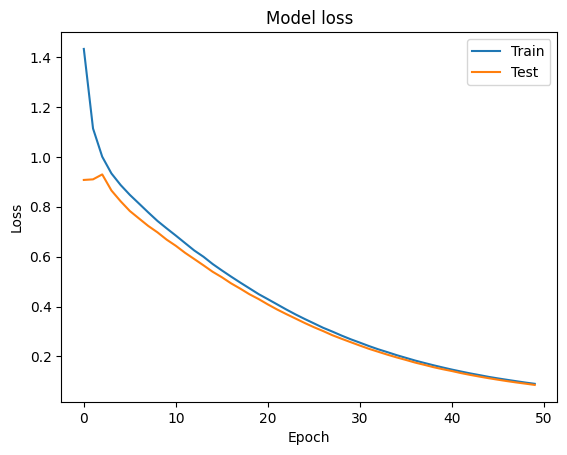

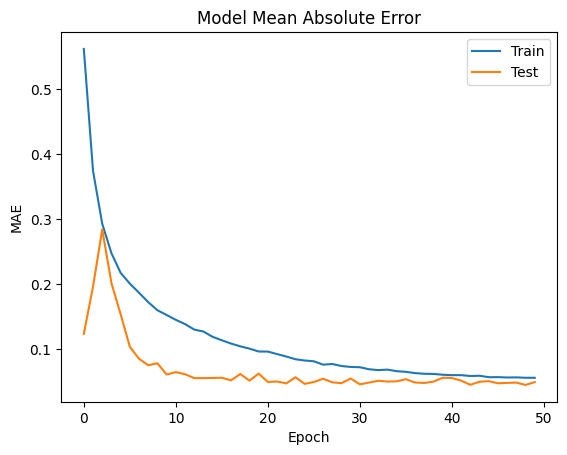

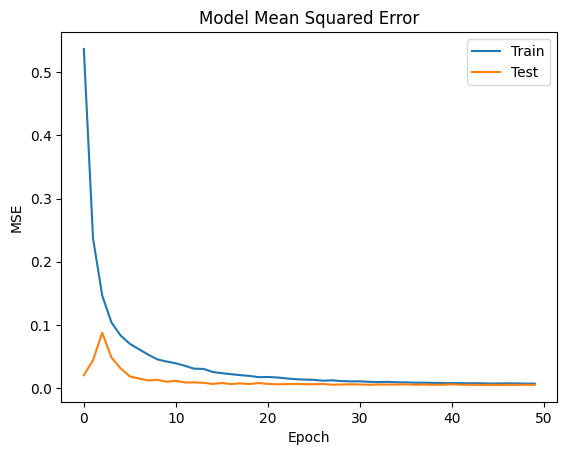

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plot training & validation MSE values
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.show()

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/DS/CSVs/Output_Shishper_Glacier_Coordinates_Optimized/combined_data.csv')



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Assume df is already loaded with your data
df = pd.read_csv('/content/drive/MyDrive/DS/CSVs/Output_Shishper_Glacier_Coordinates_Optimized/combined_data.csv')
# Select the columns to normalize
columns_to_normalize = ['v [m/yr]', 'v_error [m/yr]', 'vx [m/yr]', 'vx_error [m/yr]', 'vy [m/yr]', 'vy_error [m/yr]']

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[columns_to_normalize])

# Create sequences
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:(i + timesteps)]
        sequences.append(seq)
    return np.array(sequences)

timesteps = 10
features = scaled_data.shape[1]
data_sequences = create_sequences(scaled_data, timesteps)

# Split into features and targets
X = data_sequences[:, :-1]
y = data_sequences[:, -1, 0]  # Assuming you want to predict the first column 'v [m/yr]'

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Input(shape=(timesteps - 1, features)))
model.add(LSTM(50, kernel_regularizer=l2(0.01), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(50, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(1))
optimizer = Adam(learning_rate=0.00005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

# Path to save the model in Google Drive
model_save_path = '/content/drive/MyDrive/DS/trained_models/best_model.keras'

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, mode='min')
]

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), callbacks=callbacks)


In [ ]:
!itslive-export --lat 76.511 --lon -36.185 --format csv --outdir shishper_test

Processing 1 coordinates... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:08


In [ ]:
ls

drive/  sample_data/  shishper_test/


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load your scaler and model
scaler = MinMaxScaler()
model = load_model('best_model.keras')

# Load new data
new_data = pd.read_csv('new_data.csv')

# Normalize the new data
new_scaled_data = scaler.transform(new_data[['v [m/yr]', 'vx [m/yr]', 'vy [m/yr]', 'v_error [m/yr]', 'vx_error [m/yr]', 'vy_error [m/yr]']])

# Create sequences
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:(i + timesteps)]
        sequences.append(seq)
    return np.array(sequences)

timesteps = 10
new_data_sequences = create_sequences(new_scaled_data, timesteps)

# Extract features for prediction
X_new = new_data_sequences[:, :-1]

# Make predictions
predictions = model.predict(X_new)

# Inverse transform the predictions if necessary
predicted_v = scaler.inverse_transform(predictions)

# Print or save the predictions
print(predicted_v)


ValueError: File not found: filepath=best_model.keras. Please ensure the file is an accessible `.keras` zip file.